# Attempt to extract refractive index from time domain

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel, c 
from Matrix_methods.TimeDomain_extractor import TimeDomainExtractor

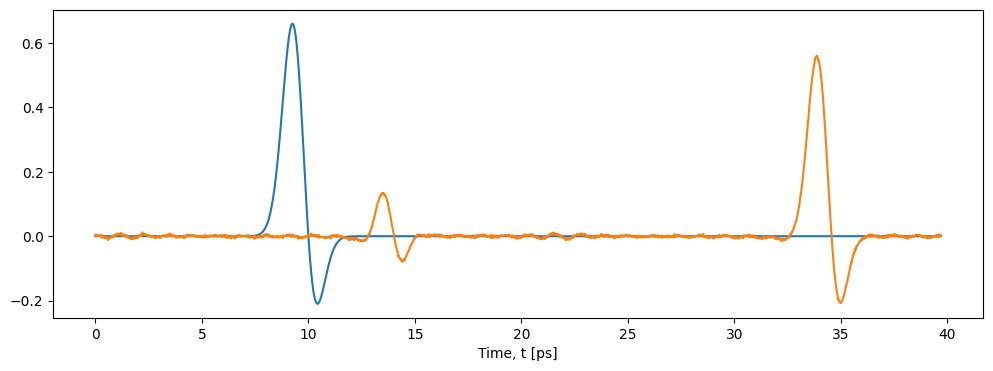

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**11  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

# Experimental material parameters (ground truth)
material_params_exp = [(3.46+0.01j, 3 * 1e-3)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0.002)
experimental_pulse = experimental_pulse[:L]


plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

In [3]:
# Initial guesses
n_init, k_init, D_init = 3.40, 0.015, 3e-3

# Create and run the optimizer
extractor = TimeDomainExtractor(reference_pulse, experimental_pulse, deltat, n_init, k_init, D_init, lr=0.001)
optimized_n, optimized_k, optimized_D = extractor.optimize(num_iterations=100, updates=10, alpha=1)

initial_params = [(n_init + 1j*k_init, D_init)]
initial_pulse = simulate_parallel(reference_pulse, initial_params, deltat)[1][:L]

Optimizing for 100 with loss multiplier 1.
Iteration 0, Loss: 0.00987747497856617, n: 3.3990001678466797, k: 0.0139999995008111, D: 0.0029999997932463884
Iteration 10, Loss: 0.0071668075397610664, n: 3.4003798961639404, k: 0.004747746046632528, D: 0.0029999997932463884
Iteration 20, Loss: 0.004957092460244894, n: 3.4086010456085205, k: -0.0031692227348685265, D: 0.0029999997932463884
Iteration 30, Loss: 0.0036316076293587685, n: 3.4172372817993164, k: -0.008583836257457733, D: 0.0029999997932463884
Iteration 40, Loss: 0.0027765133418142796, n: 3.4253005981445312, k: -0.011497067287564278, D: 0.0029999997932463884
Iteration 50, Loss: 0.002180833136662841, n: 3.4325811862945557, k: -0.012306714430451393, D: 0.0029999997932463884
Iteration 60, Loss: 0.0017129512270912528, n: 3.4390900135040283, k: -0.011462151072919369, D: 0.0029999997932463884
Iteration 70, Loss: 0.001301207346841693, n: 3.444880247116089, k: -0.009334125556051731, D: 0.0029999997932463884
Iteration 80, Loss: 0.000944579

[((3.4575555324554443+0.0017233520047739148j), 0.0029999997932463884)]


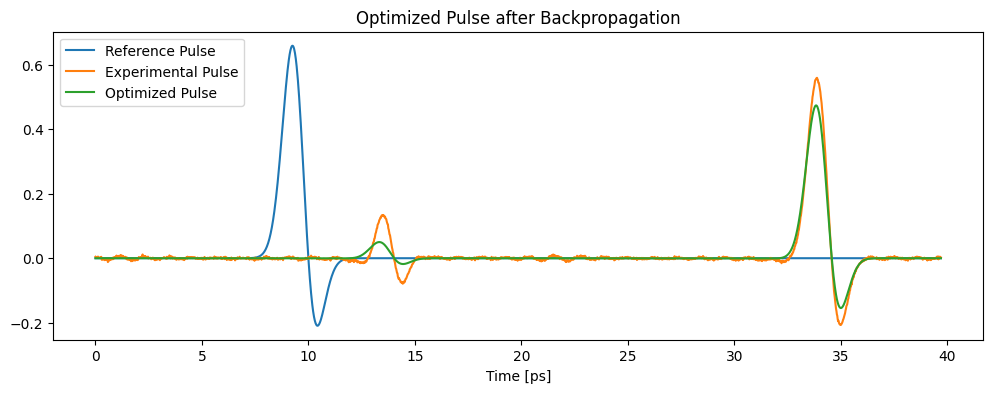

In [4]:
best_params = [(optimized_n + 1j*optimized_k, optimized_D)]
print(best_params)
best_pulse = simulate_parallel(reference_pulse, best_params, deltat)[1][:L]

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
#plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, best_pulse.detach().numpy(), label='Optimized Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()

In [5]:
print(f'forward pass single run time: {extractor.forward_time}s')
print(f'backwards pass single run time: {extractor.backwards_time}s')
print(f'optimizer single run time: {extractor.optimizer_time}s')

forward pass single run time: 0.34131566699943505s
backwards pass single run time: 0.6150385419896338s
optimizer single run time: 0.0001782919862307608s


In [6]:
print(f'forward pass 100 iter run time: {extractor.forward_time * 100} s')
print(f'backwards pass 100 iter run time: {extractor.backwards_time * 100} s')
print(f'optimizer 100 iter run time: {extractor.optimizer_time * 100} s')

forward pass 100 iter run time: 34.131566699943505 s
backwards pass 100 iter run time: 61.50385419896338 s
optimizer 100 iter run time: 0.01782919862307608 s
